In [1]:
import anndata
import numpy as np
import sys
import torch
sys.path.append('../../../')
import velovae as vv

In [2]:
dataset = 'IPSC'
root = "/scratch/blaauw_root/blaauw1/gyichen"
adata = anndata.read_h5ad(f'{root}/data/velovae/continuous/{dataset}/{dataset}.h5ad')

In [ ]:
#vv.preprocess(adata, n_gene=2000, min_shared_counts=20, compute_umap=True)
#adata.write_h5ad(f'data/{dataset}_pp.h5ad')

In [3]:
model_path_base = f'{root}/checkpoints/{dataset}'
figure_path_base = f'{root}/figures/{dataset}'
data_path = f'{root}/data/velovae/brode/{dataset}'
gene_plot = ['Vim','Nr2f1', 'Krt7', 'H19']

# Branching ODE

Graph Partition
Number of partitions:  2
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.
Learning Rate based on Data Sparsity: 0.0003
------------------------ Train a Branching ODE ------------------------
             Epithelial  IPS  MET  Neural  Stromal  Trophoblast
Epithelial          0.0  0.0  1.0     0.0      0.0          0.0
IPS                 1.0  0.0  0.0     0.0      0.0          0.0
MET                 0.0  0.0  1.0     0.0      0.0          0.0
Neural              0.0  0.0  1.0     0.0      0.0          0.0
Stromal             1.0  0.0  0.0     0.0      0.0          0.0
Trophoblast         1.0  0.0  0.0     0.0      0.0          0.0
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.    

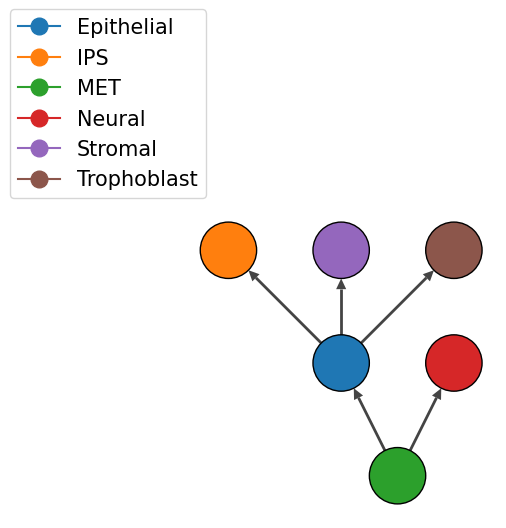

In [4]:
figure_path = f'{figure_path_base}/BrODE'
model_path = f'{model_path_base}/BrODE'

torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata,
                 'clusters',
                 'fullvb_time',
                 'fullvb_z',
                 param_key='fullvb',
                 device='cuda:0')

brode.train(adata,
            'fullvb_time',
            'clusters',
            plot=False,
            gene_plot=gene_plot,
            figure_path=figure_path)

brode.save_model(model_path, 'brode')
brode.save_anndata(adata, 'brode', data_path, file_name=f'{dataset}.h5ad')

vv.plot_transition_graph(adata, save=f'{figure_path_base}/transition.png')

# Evaluation

In [5]:
Ek = np.mean(adata.layers['brode_velocity_u']**2, 0) + np.mean(adata.layers['brode_velocity']**2, 0)
gidx = np.argsort(Ek)[-50:]

---   Plotting  Results   ---
computing velocity graph (using 13/32 cores)


  0%|          | 0/26682 [00:00<?, ?cells/s]

    finished (0:04:45) --> added 
    'brode_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'brode_velocity_embed', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/blaauw_root/blaauw1/gyichen/figures/IPSC/eval_brode_stream.png


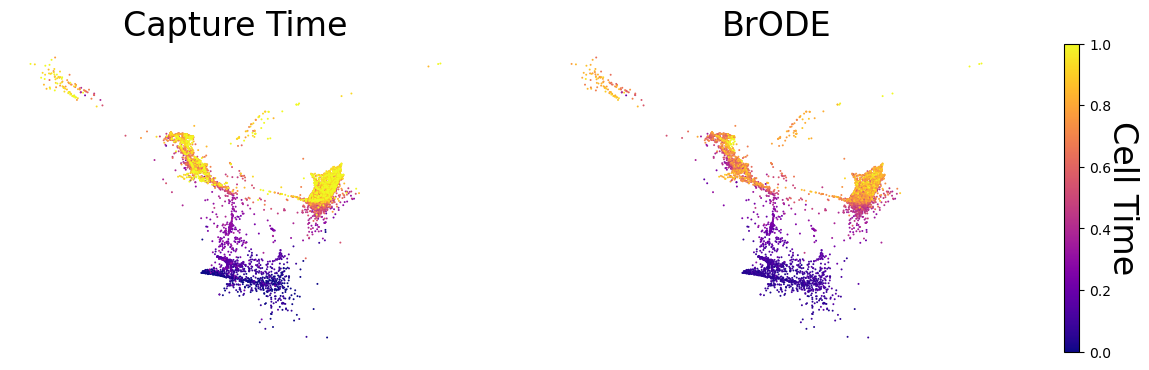

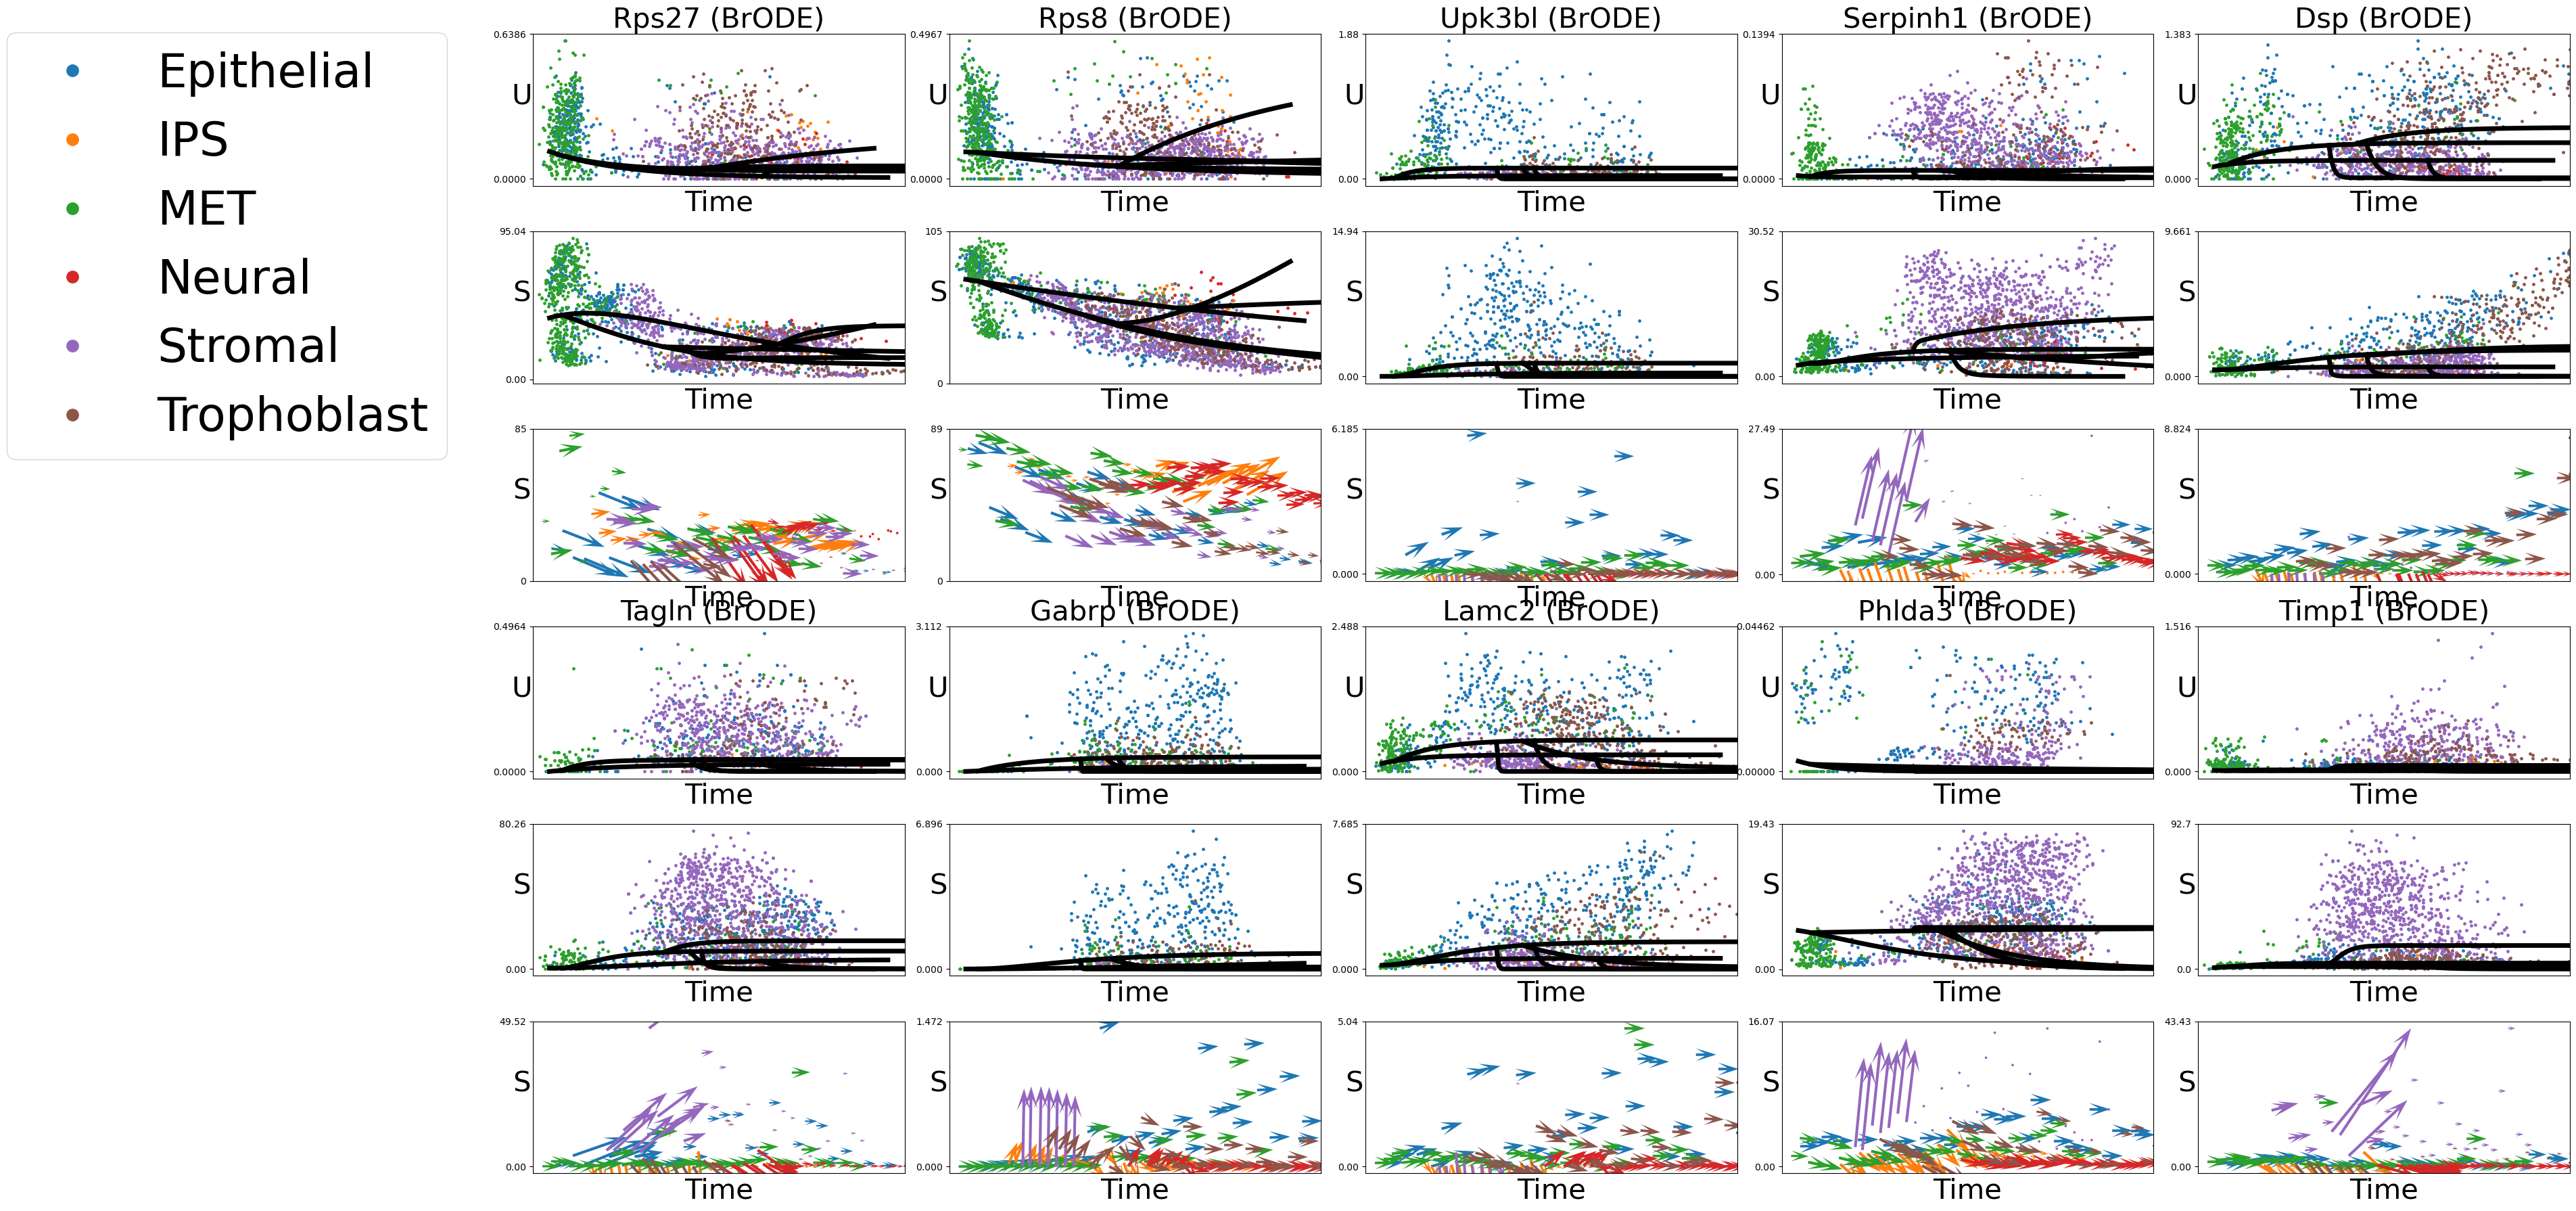

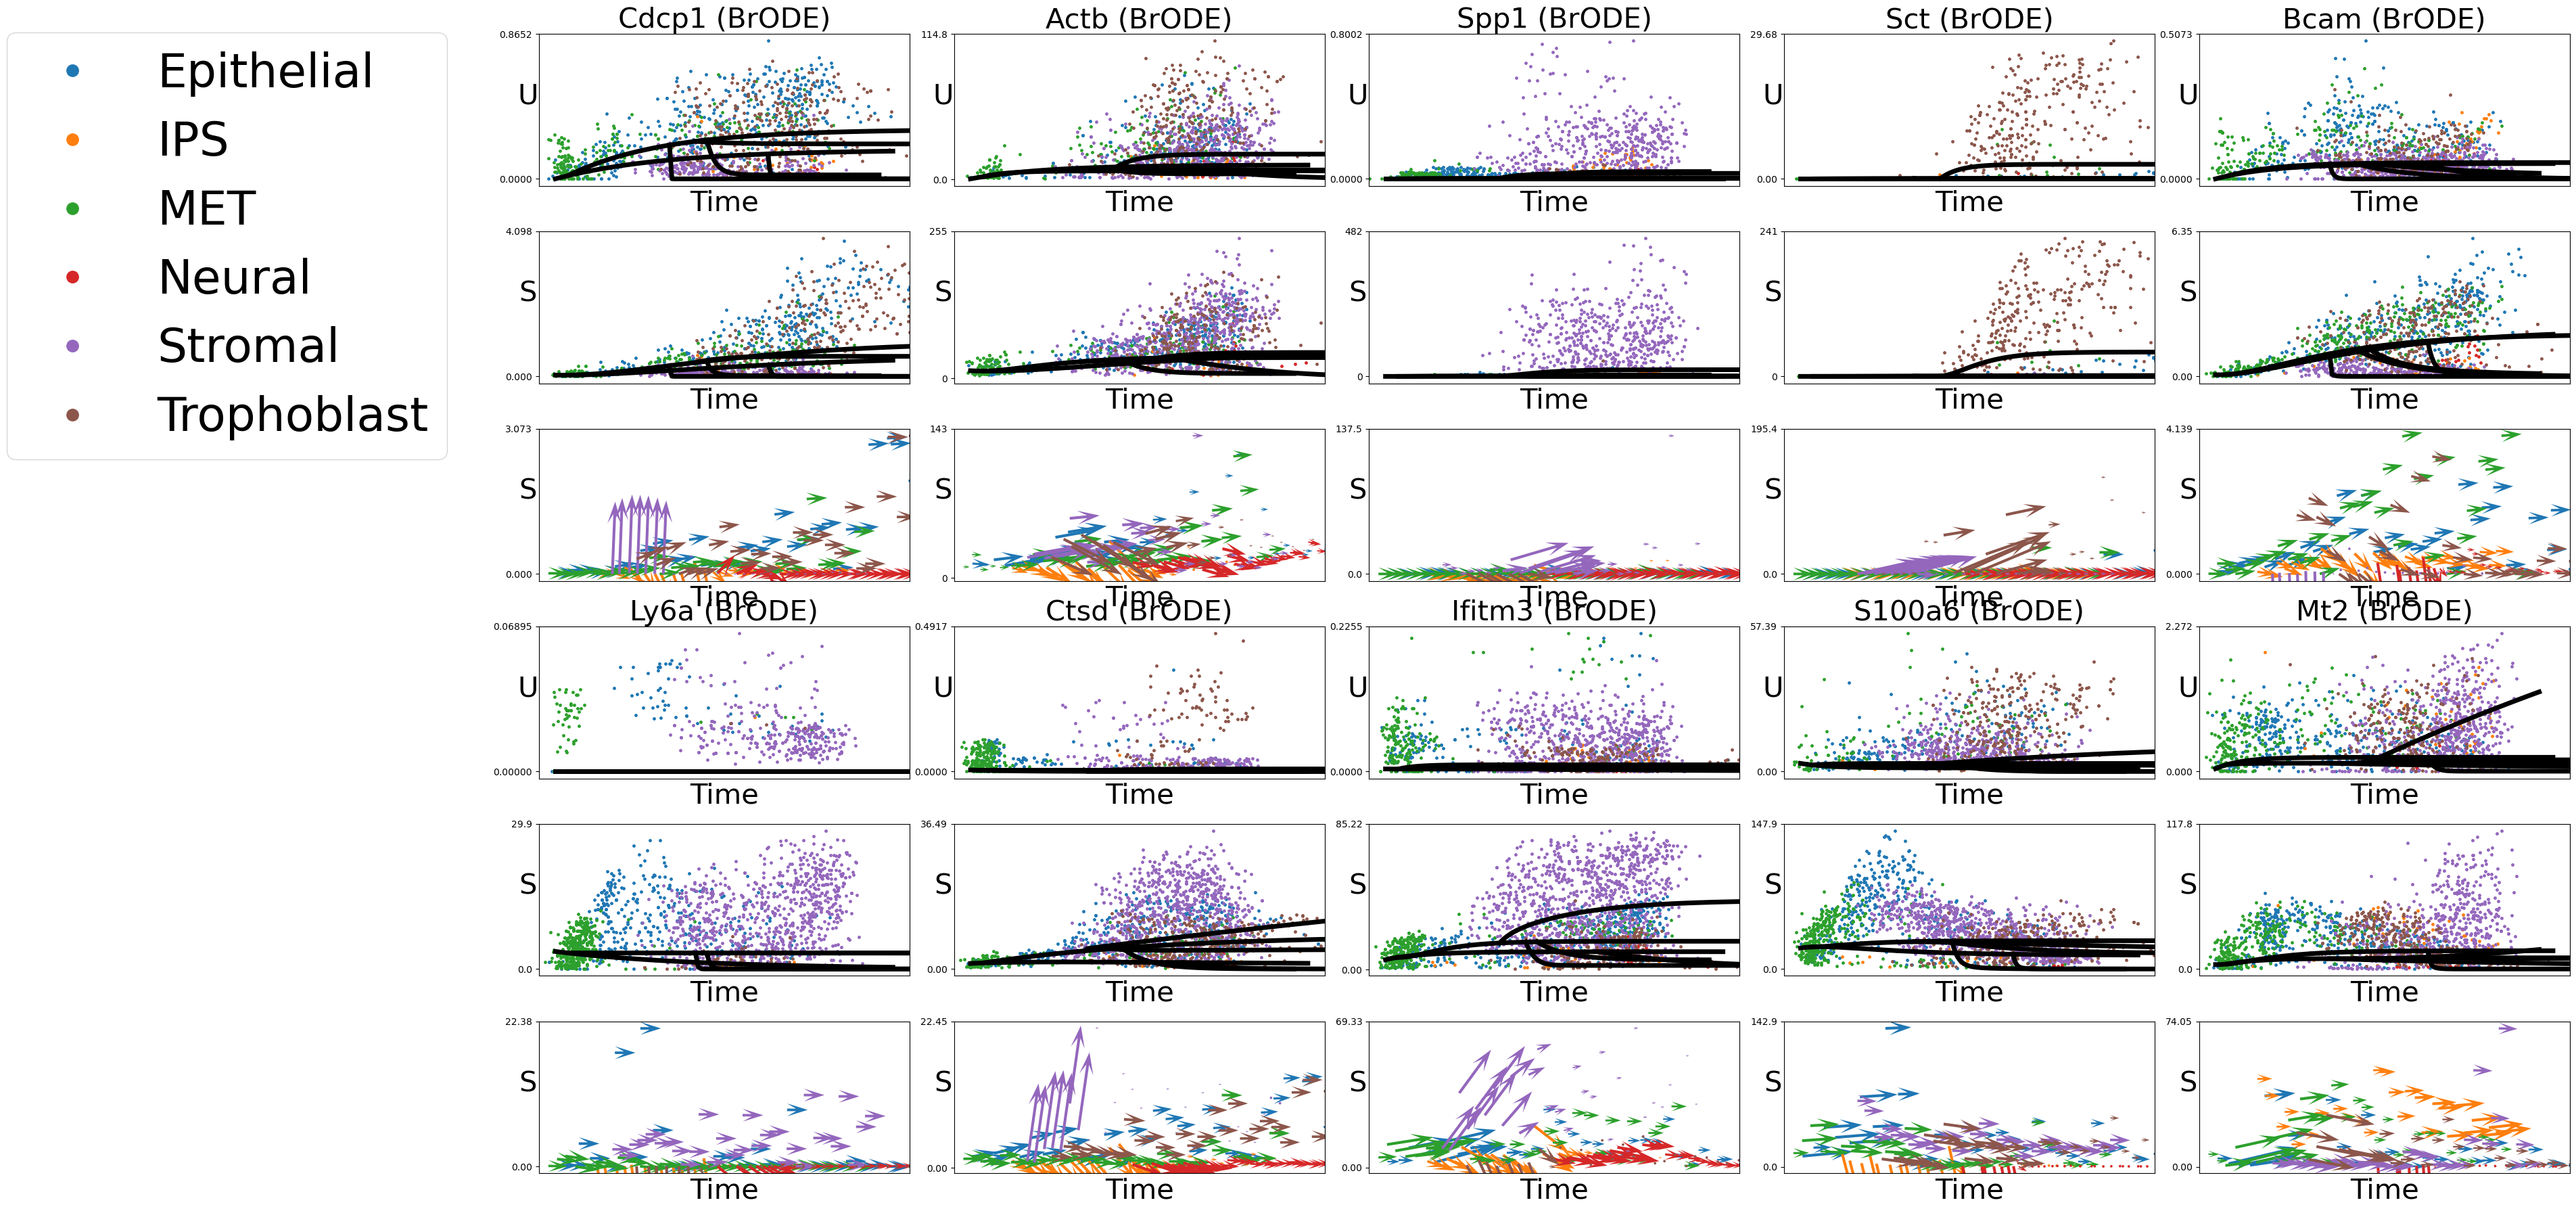

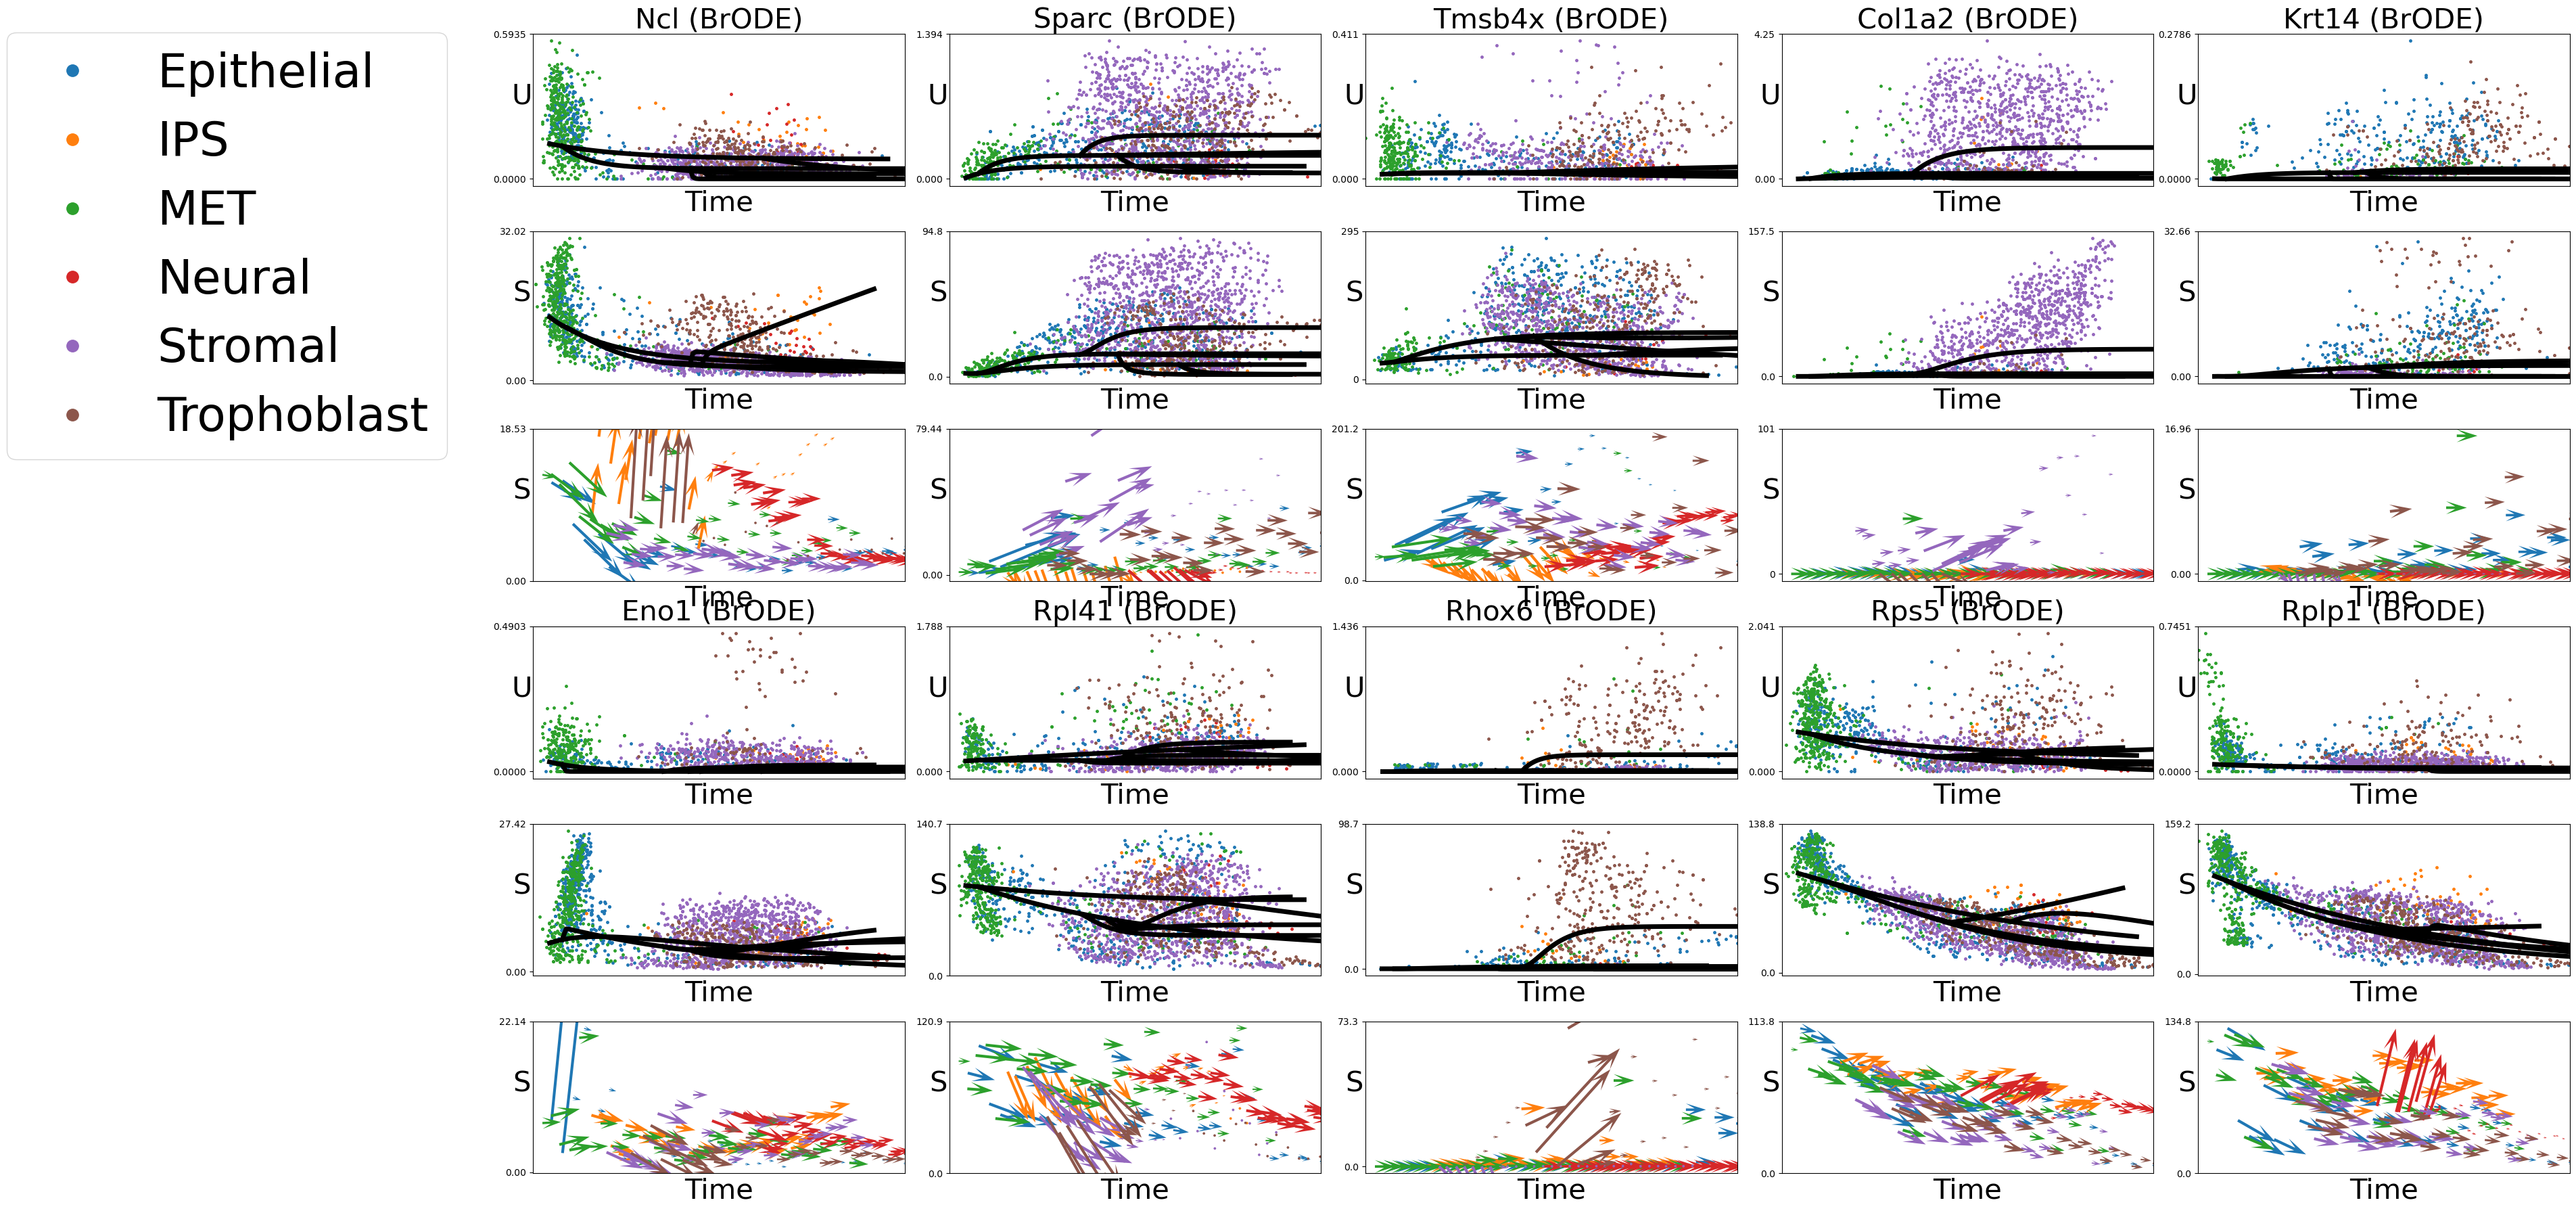

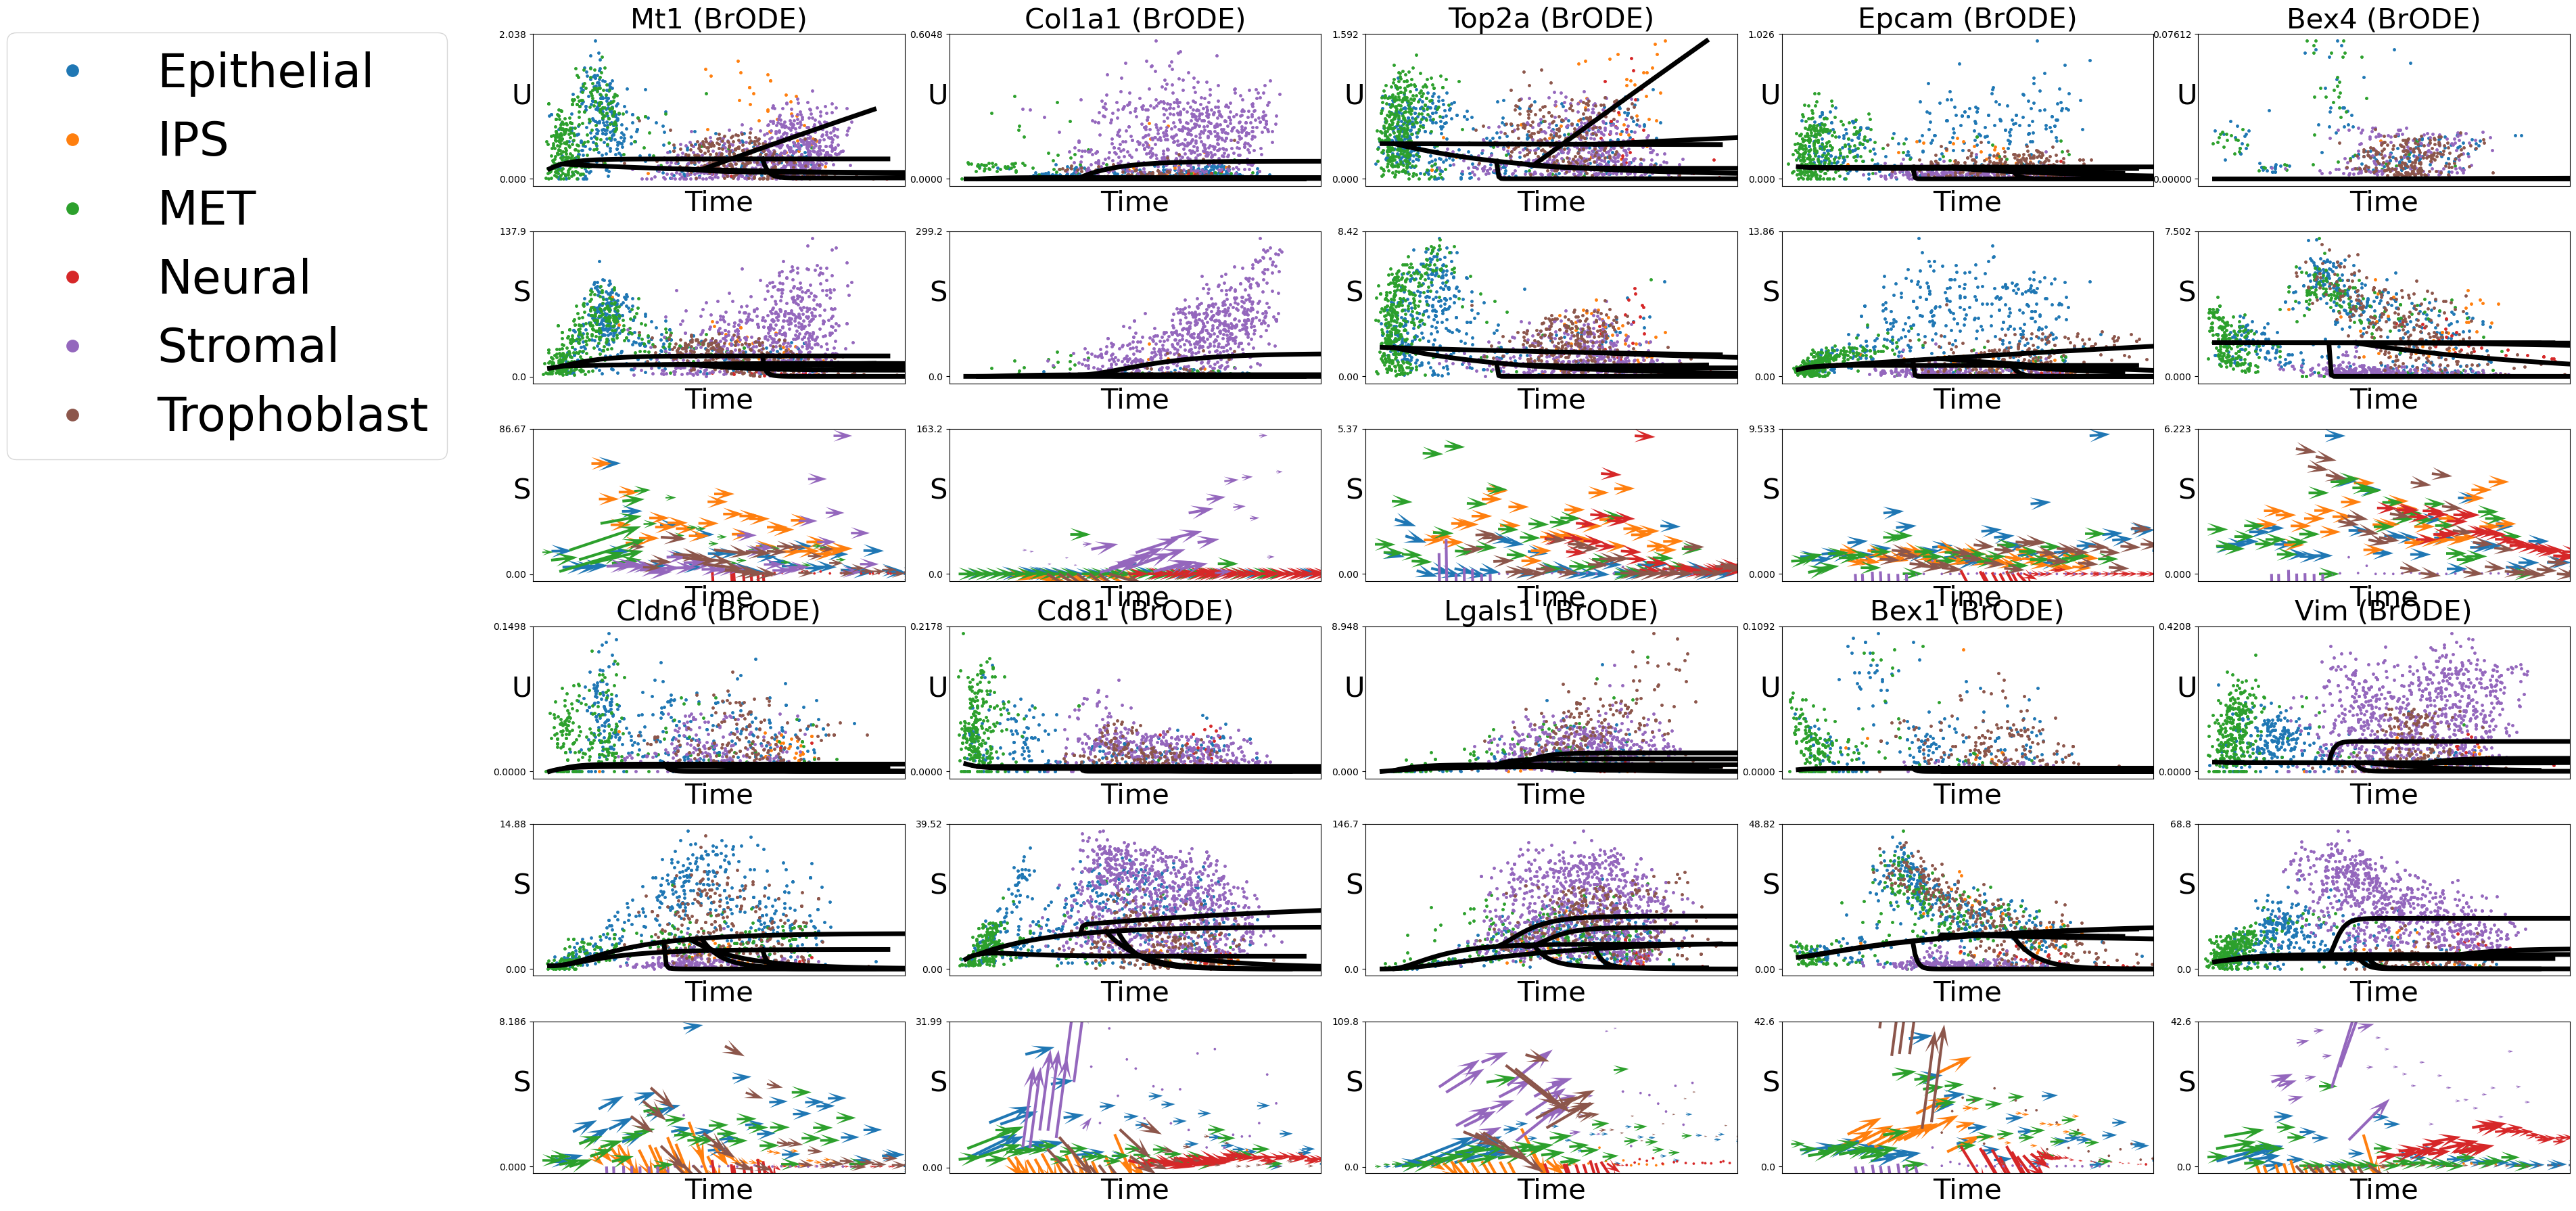

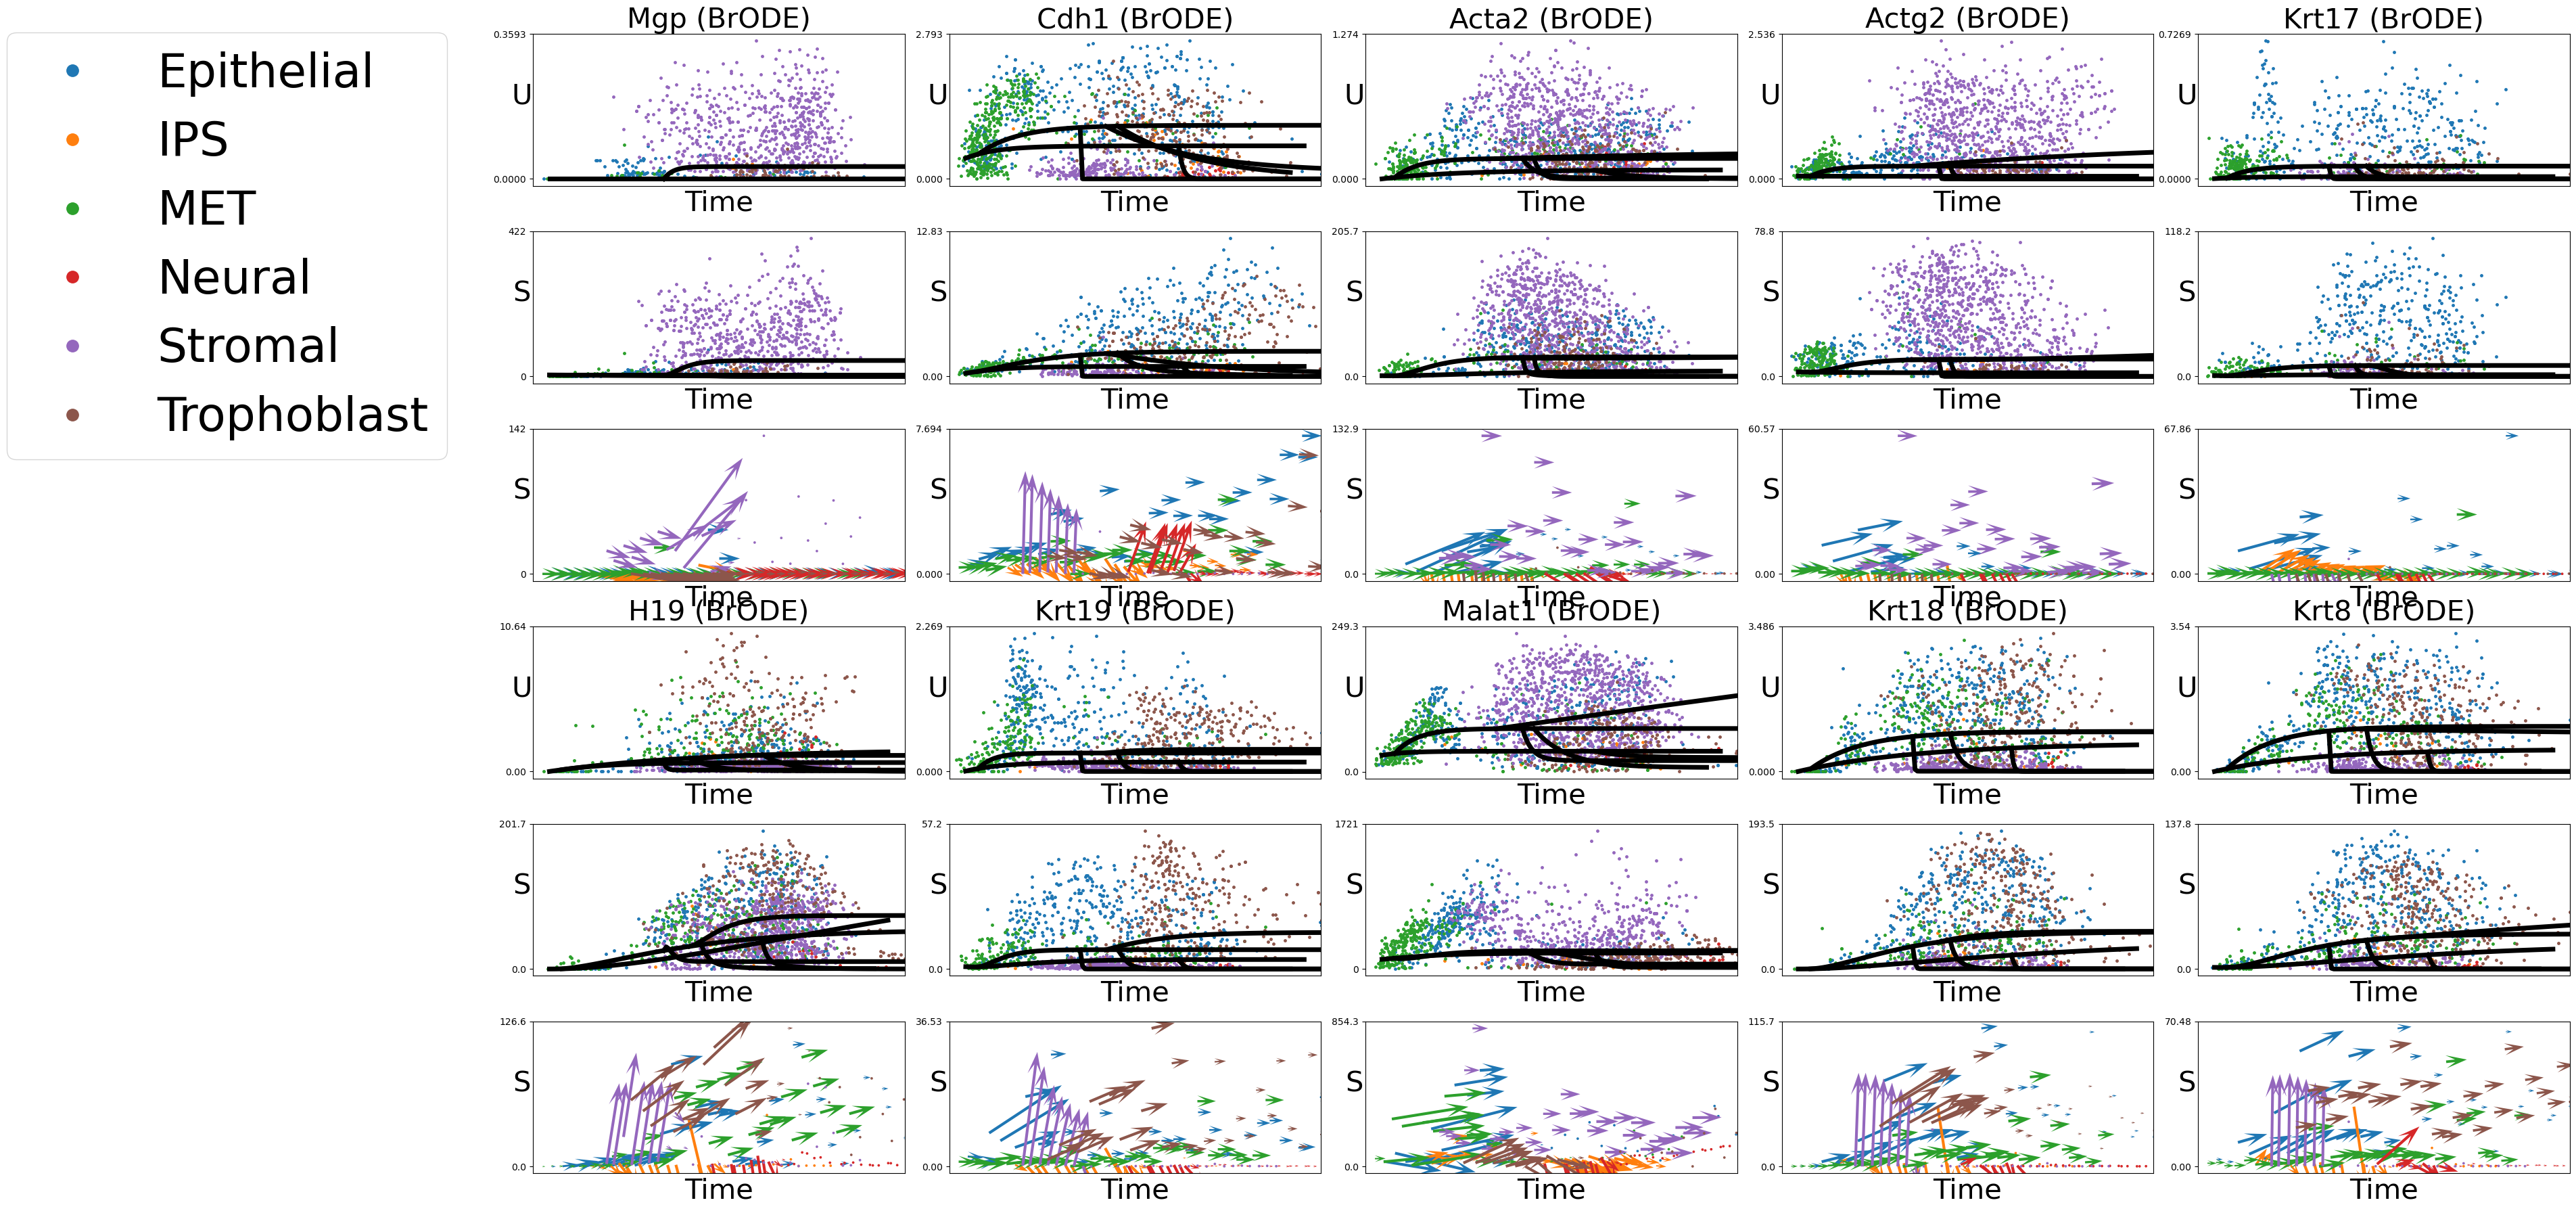

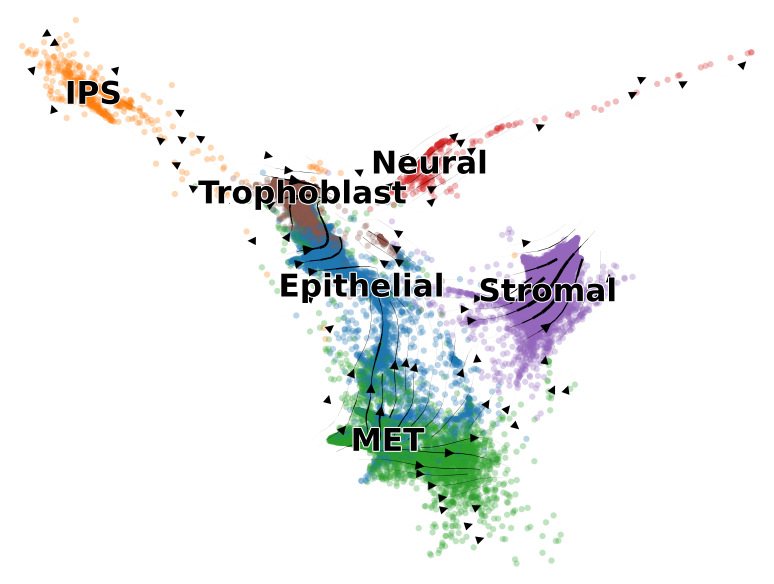

In [6]:
res, res_type = vv.post_analysis(adata,
                                 'eval',
                                 ['BrODE'],
                                 ['brode'],
                                 compute_metrics=False,
                                 genes=adata.var_names[gidx],
                                 grid_size=(2,5),
                                 embed='embed',
                                 figure_path=figure_path_base)